In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix,
                             recall_score, precision_score, 
                             f1_score, roc_auc_score, 
                             accuracy_score, balanced_accuracy_score)

from scipy.stats import randint

In [2]:
X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
model = RandomForestClassifier(random_state=42)

param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': randint(10, 30)
}
cv = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=20, cv=5, n_jobs=-1, random_state=42)
cv.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x158365c30>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x105a11480>},
                   random_state=42)

In [4]:
def plot_mat(model, X_valid, y_valid):
    np.seterr(divide='ignore')

    y_pred_valid = model.predict(X_valid)
    y_pred_valid = np.where(y_pred_valid > 0.5, 1, 0)
    cm = confusion_matrix(y_valid, y_pred_valid)

    precision = precision_score(y_valid, y_pred_valid, zero_division=1)
    recall = recall_score(y_valid, y_pred_valid, zero_division=1)
    f1 = f1_score(y_valid, y_pred_valid, zero_division=1)
    roc_auc = roc_auc_score(y_valid, y_pred_valid)
    accuracy = accuracy_score(y_valid, y_pred_valid)
    balanced_accuracy = balanced_accuracy_score(y_valid, y_pred_valid)

    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'ROC AUC: {roc_auc:.4f}')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Balanced Accuracy: {balanced_accuracy:.4f}')
    print(classification_report(y_valid, y_pred_valid, zero_division=1))

    cm_procent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    try:
        classes = model.classes_
    except AttributeError:
        classes = [0, 1]

    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_procent[i, j]
            if i == j:
                s = cm.sum(axis=1)[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)

    try:
        ax = sns.heatmap(np.round(cm_procent,2), 
            annot=annot, 
            xticklabels=classes, 
            yticklabels=classes,
            cmap='Greens', fmt='')
    except TypeError:
        ax = sns.heatmap(np.round(cm_procent,2), 
            annot=annot,
            cmap='Greens', fmt='')

    ax.set(xlabel='Predict', ylabel='Actual')

Precision: 0.8673
Recall: 0.9043
F1 Score: 0.8854
ROC AUC: 0.8908
Accuracy: 0.8900
Balanced Accuracy: 0.8908
              precision    recall  f1-score   support

           0       0.91      0.88      0.89       106
           1       0.87      0.90      0.89        94

    accuracy                           0.89       200
   macro avg       0.89      0.89      0.89       200
weighted avg       0.89      0.89      0.89       200



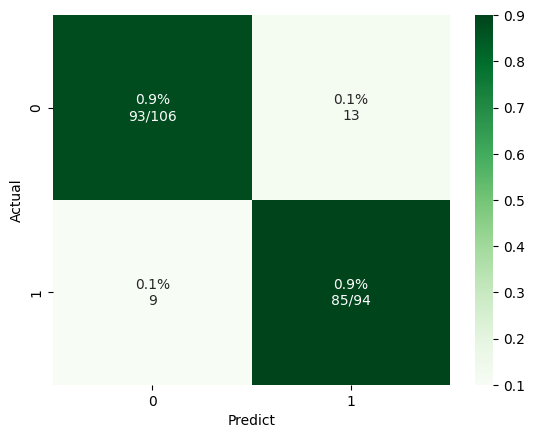

In [5]:
model = cv.best_estimator_
plot_mat(model, X_test, y_test)